# NLP Project: The State of Kanye West

In [3644]:
# Main Imports
import re
import requests
import pandas as pd
import numpy as np
import json
import time
import string
import warnings

#Graphing Stuff
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#NLTK items
from nltk.corpus import stopwords

#Scraping
from bs4 import BeautifulSoup

#sklearn dohickeys
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import LatentDirichletAllocation, NMF

#gensim things
from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()


How has Kanye's changed as an artist and person and what can we learn using machine learning on bipolar?
- Topic Modeling
    - Static
    - Dynamic
- NLP
- Recursive Neural Network
    - Word 2 Vec


## 1.0 Data Collection

Will use Orion API seed to pull lyrics, first will start with a test pull

In [2647]:
## Lets load in our keys as variables below 
with open('./keys/orion_keys.txt') as f:
       orion_keys = {'api_key' : f.read().split(',')[0]}

In [2648]:
artist = "Kanye%West"

In [2649]:
song = "Gold%20Digger"

In [2650]:
url = "https://orion.apiseeds.com/api/music/lyric/" + artist + "/" + song + "?apikey=" + orion_keys['api_key']

'https://orion.apiseeds.com/api/music/lyric/Kanye%West/Gold%20Digger?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr'

In [11]:
res = requests.get(url)
res.status_code

200

_Status Code return at 200, Will check now what data looks like_

In [13]:
data = res.json() # Store data that is pulled

In [23]:
data['result']['track'].keys() # Keys in Dictionary

dict_keys(['name', 'text', 'lang'])

In [24]:
data['result']['track']['name'] # Track Name

'Gold Digger'

###  1.1 Pull Song Lyrics Function

In [36]:
# Since we will be pulling multiple songs, best to build a function to do so

In [3]:
def gold_digger(artist, song_list,exclude_list):
    after= None 
    skipped_list = []
    
    for i in range(len(song_list)):
        if song_list[i].replace(' ','%') not in exclude_list:
            url = "https://orion.apiseeds.com/api/music/lyric/" + artist + "/" + song_list[i].replace(' ','%') + "?apikey=" + orion_keys['api_key']
        else:
            pass
        
        current_track = []
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after
        print(current_url)
        res = requests.get(current_url)
        #print(res.status_code)
        if res.status_code != 200:
            print('Status error: ', res.status_code)
            skipped_list.append(song_list[i])
            pass
        else:
            current_dict = res.json()
            current_dict['result']['track'].pop('lang', None)
            current_track = []
            current_track.append(current_dict['result']['track'])

            time.sleep(5)

            if i > 0:
                current_df = pd.DataFrame(current_track)
                prev_songs = pd.read_csv(artist + '.csv')
                all_posts = pd.concat([prev_songs,current_df])
                all_posts.to_csv(artist + '.csv', index=False)
            else:
                current_df = pd.DataFrame(current_track)
                current_df.to_csv(artist + '.csv', index=False)
                all_posts = current_df
    return skipped_list

In [10]:
# Create list of songs to search over
song_list = [song]
exclude_list = []

In [13]:
# Test function
gold_digger(artist,song_list,exclude_list=exclude_list)

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Gold%20Digger?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr


[]

### 1.2 Get Kanye's Discography

In [2879]:
# Import Spotipy Library to access data about discography
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials

In [3572]:
## Lets load in our keys as variables below 
with open('./keys/spotify_keys.txt') as f:
    cid, cids = f.read().split(',')

In [3573]:
spotify_keys = {"client_id": cid,
                "client_secret": cids
               }

In [3574]:
# Save Spotify Dev credential for searches
cred = SpotifyClientCredentials(client_id=spotify_keys['client_id'],client_secret=spotify_keys['client_secret'])

In [3575]:
# Instantiate Spotify wrapper with access token
sp = Spotify(auth=cred.get_access_token())

In [19]:
# Kanye's Spoitfy id
Kanye_spotify_id = '5K4W6rqBFWDnAN6FQUkS6x'
album_dict = sp.artist_albums(Kanye_spotify_id,country='US')

In [20]:
album_dict['items'][0] # Review Dictionary Structure for spotipy 

{'album_group': 'album',
 'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2hPgGN4uhvXAxiXQBIXOmE'},
   'href': 'https://api.spotify.com/v1/artists/2hPgGN4uhvXAxiXQBIXOmE',
   'id': '2hPgGN4uhvXAxiXQBIXOmE',
   'name': 'KIDS SEE GHOSTS',
   'type': 'artist',
   'uri': 'spotify:artist:2hPgGN4uhvXAxiXQBIXOmE'},
  {'external_urls': {'spotify': 'https://open.spotify.com/artist/5K4W6rqBFWDnAN6FQUkS6x'},
   'href': 'https://api.spotify.com/v1/artists/5K4W6rqBFWDnAN6FQUkS6x',
   'id': '5K4W6rqBFWDnAN6FQUkS6x',
   'name': 'Kanye West',
   'type': 'artist',
   'uri': 'spotify:artist:5K4W6rqBFWDnAN6FQUkS6x'},
  {'external_urls': {'spotify': 'https://open.spotify.com/artist/0fA0VVWsXO9YnASrzqfmYu'},
   'href': 'https://api.spotify.com/v1/artists/0fA0VVWsXO9YnASrzqfmYu',
   'id': '0fA0VVWsXO9YnASrzqfmYu',
   'name': 'Kid Cudi',
   'type': 'artist',
   'uri': 'spotify:artist:0fA0VVWsXO9YnASrzqfmYu'}],
 'external_urls': {'spotify': 'https://open.spot

In [21]:
album_dict['items'][0]['id'] # Spotify Album ID

'6pwuKxMUkNg673KETsXPUV'

In [22]:
album_dict['items'][0]['name'] # Spotify Albun Name

'KIDS SEE GHOSTS'

In [23]:
album_dict['items'][0]['release_date'] # Spotify Album Release Date

'2018-06-08'

In [24]:
album_dict['items'][0]['total_tracks'] # Tracks per album

7

In [25]:
len(album_dict['items']) # Total Albums

20

In [26]:
kanye_albums = [p for p in album_dict['items']] # Create list of Kanye's discography

In [27]:
df_albums = pd.DataFrame(kanye_albums)

In [3714]:
df_albums.head()

,album_group,album_type,artists,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,type,uri
0,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/6p...,https://api.spotify.com/v1/albums/6pwuKxMUkNg6...,6pwuKxMUkNg673KETsXPUV,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",KIDS SEE GHOSTS,2018-06-08,day,7,album,spotify:album:6pwuKxMUkNg673KETsXPUV
1,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/5E...,https://api.spotify.com/v1/albums/5EBGCvO6upi3...,5EBGCvO6upi3GNknMVe9x9,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",ye,2018-06-01,day,7,album,spotify:album:5EBGCvO6upi3GNknMVe9x9
2,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/7g...,https://api.spotify.com/v1/albums/7gsWAHLeT0w7...,7gsWAHLeT0w7es6FofOXk1,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Life Of Pablo,2016-06-10,day,20,album,spotify:album:7gsWAHLeT0w7es6FofOXk1
3,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/7D...,https://api.spotify.com/v1/albums/7D2NdGvBHIav...,7D2NdGvBHIavgLhmcwhluK,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Yeezus,2013-01-01,day,10,album,spotify:album:7D2NdGvBHIavgLhmcwhluK
4,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/20...,https://api.spotify.com/v1/albums/20r762YmB5He...,20r762YmB5HeofjMCiPMLv,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",My Beautiful Dark Twisted Fantasy,2010-01-01,day,13,album,spotify:album:20r762YmB5HeofjMCiPMLv


In [318]:
album_list = list(df_albums.name.unique())
print(album_list)

['KIDS SEE GHOSTS', 'ye', 'The Life Of Pablo', 'Yeezus', 'My Beautiful Dark Twisted Fantasy', '808s & Heartbreak', 'Graduation', 'Late Registration', 'The College Dropout', 'The College Dropout (Edited)', 'I Love It [(Freaky Girl) Edit]', 'I Love It', 'XTCY', 'Lift Yourself']


In [320]:
# Find out the number of albums
num_albums = len(album_list)
print(num_albums)

14


#### Some Data Organizing

In [3611]:
# Make a function to clean song name before adding to a dictionary for mapping
def lowercase_certain_words(strings,word_list):
    string_list = []
    extra_words = ['Freestyle Live From Singapore', 'Bonus Track', 'Freaky Girl Edit', 'Lil Pump']
    for char in string.punctuation:
        strings.replace(char,"")         
    for words in extra_words:
        strings.replace(words,"")
    for word in strings.split(' '):
        if word not in word_list:
            string_list.append(word)
        else:
            string_list.append(word.lower())
    strings = " ".join(string_list)
    return strings

In [3614]:
# Make dictionary for mapping data together
album_date_dict = {}
album_song_dict = {}
album_tracknum_dict = {}

for album_id in df_albums.id:
    #print(album_id)
    album_name = df_albums.loc[(df_albums.id==album_id),'name'].values[0] #map id to name to use as key in 
    
    album_tracks = []
    temp_dict = {}
    temp_dict = sp.album_tracks(album_id=album_id)
    album_tracknum_dict[album_name] = len(temp_dict['items']) #Store number of tracks on an album to a dictionary
                                          
    #print(len(temp_dict['items']))
    album_tracks = [temp_dict['items'][i]['name'] for i in range(0,len(temp_dict['items']))]
    
    for track in album_tracks:
        track = lowercase_certain_words(track,['Of','A','The','In'])
        album_song_dict[track] = album_name # store album associated with song to a dictionary

# Make a dictionary to map album to release date
for album in album_list:
    album_date_dict[album] = df_albums.loc[df_albums.name == album,'release_date'].unique()[0]


In [3651]:
album_song_dict['Freeee (Ghost Town, Pt. 2)'] = 'KIDS SEE GHOSTS'
album_song_dict['Blood On The Leaves'] = 'Yeezus'
album_song_dict['Power'] ='My Beautiful Dark Twisted Fantasy'
album_song_dict['All Of The Lights (Interlude)'] = 'My Beautiful Dark Twisted Fantasy'
album_song_dict['Who Will Survive In America'] = 'My Beautiful Dark Twisted Fantasy'
album_song_dict['The Glory'] = 'Graduation'
album_song_dict['Diamonds From Sierra Leone (Remix)'] ='Late Registration'
album_song_dict['The New Workout Plan'] = 'The College Dropout'
album_song_dict['Breathe In Breathe Out'] = 'The College Dropout'
album_song_dict['Feel The Love'] = 'KIDS SEE GHOSTS'
album_song_dict['Father Stretch My Hands Pt 1']= 'The Life Of Pablo'
album_song_dict['Pt 2']= 'The Life Of Pablo'
album_song_dict['Franks Track'] = 'The Life Of Pablo'
album_song_dict['No More Parties In LA'] ='The Life Of Pablo'
album_song_dict['Im In It'] = 'Yeezus'
album_song_dict['Pinocchio Story'] = '808s & Heartbreak'
album_song_dict['Skit 1'] = 'Late Registration'
album_song_dict['Skit 2'] = 'Late Registration'
album_song_dict['Skit 3'] = 'Late Registration'
album_song_dict['Skit 4'] = 'Late Registration'
album_song_dict['Diamonds From Sierra Leone'] = 'Late Registration'
album_song_dict['I Love It'] = 'I Love It'


#### Condense song title and album into lists for reference

In [29]:
# Create List of all songs using album ID from Spotify
album_song_list = [sp.album_tracks(album_id=album_id)['items'] for album_id in df_albums.id]

In [2912]:
album_song_list[0][0]['name']

'Feel The Love'

In [2830]:
# Clean redundant album list
album_list.remove('I Love It [(Freaky Girl) Edit]')
album_list

['KIDS SEE GHOSTS',
 'ye',
 'The Life Of Pablo',
 'Yeezus',
 'My Beautiful Dark Twisted Fantasy',
 '808s & Heartbreak',
 'Graduation',
 'Late Registration',
 'The College Dropout',
 'I Love It',
 'XTCY',
 'Lift Yourself']

In [2845]:
# Number of Songs Collected
song_list = []

for i in range(0,len(album_song_list)):
    current_song_list = [album for album in album_song_list[i]]
    song_list.extend(current_song_list)
len(song_list)
        

219

In [31]:
# Make Dataframe of songs
df_songs = pd.DataFrame(song_list)

In [2871]:
album_dict = {}
for i in range(0,len(album_song_list)): 
    for j in range(0, len(album_song_list[i])):
        album_dict[album_song_list[i][j]['name']] = album_song_list[i][j]['artists'][0]['name']

In [32]:
# Remove duplicates to create list of songs
kanye_songs = list(df_songs.loc[~df_songs.name.str.contains('(Edited)')].name.unique())

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [33]:
# Number of Unique Songs
len(kanye_songs)

128

### 1.3 Use Function to get Lyrics

In [35]:
skip_list = []
skipped_list = gold_digger(artist,kanye_songs,skip_list)

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Feel%The%Love?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Fire?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/4th%Dimension?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Freeee%(Ghost%Town%Pt.%2)?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Reborn?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Kids%See%Ghosts?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Cudi%Montage?apikey=vd9GJitiNw0S

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Say%You%Will?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Welcome%To%Heartbreak?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Heartless?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Amazing?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Love%Lockdown?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Paranoid?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/RoboCop?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/mus

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Breathe%In%Breathe%Out?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/School%Spirit%Skit%1?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/School%Spirit?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/School%Spirit%Skit%2?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Lil%Jimmy%Skit?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Two%Words?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Through%The%Wire?apikey=vd9GJitiNw0S203ir7G0arPX

In [121]:
df_ye = pd.read_csv('./Kanye%West.csv')

####  1.3.1 Fill in Lyrics from skipped list

In [37]:
# This list were skipped during the API query, we will try to fill them in using Beautiful Soup
skipped_list

['Feel The Love',
 'Fire',
 '4th Dimension',
 'Reborn',
 'Cudi Montage',
 'Ultralight Beam',
 'Father Stretch My Hands Pt. 1',
 'Pt. 2',
 'Waves',
 'FML',
 'Real Friends',
 "Frank's Track",
 'Siiiiiiiiilver Surffffeeeeer Intermission',
 '30 Hours',
 'No More Parties In LA',
 'Hold My Liquor',
 "I'm In It",
 'Guilt Trip',
 'Send It Up',
 'Pinocchio Story (Freestyle Live From Singapore)',
 'Skit #1',
 'Skit #2',
 'Skit #3',
 'Skit #4',
 'Diamonds From Sierra Leone - Bonus Track',
 'Intro',
 'School Spirit Skit 1',
 'School Spirit Skit 2',
 'I Love It - (Freaky Girl) Edit',
 'I Love It (& Lil Pump)',
 'XTCY']

In [83]:
# Make function to scrape Genius lyrics site
def scrape_song_url(song, artist):
    song = song.replace(" ","-")
    print(song)
    url = 'https://genius.com/'+artist+'-'+song+'-lyrics'
    res = requests.get(url)
    print(url)
    if res.status_code != 200:
        artist_2 = 'kids-see-ghosts'
        url2 = 'https://genius.com/'+artist_2+'-'+song+'-lyrics'
        res = requests.get(url2)
        if res.status_code != 200:
            print('Status error: ', res.status_code)
            lyrics = ""
            pass
        else:
            html = BeautifulSoup(res.text, 'html.parser')
            lyrics = html.find('div', class_='lyrics').get_text()
    else:
        html = BeautifulSoup(res.text, 'html.parser')
        lyrics = html.find('div', class_='lyrics').get_text()

    return lyrics

In [110]:
# Clean list to be able to be used in url
for char in string.punctuation:
    skipped_list =[song.replace(char,"") for song in skipped_list]

In [116]:
# Some extra words in song name that need to be removed
extra_words = ['Freestyle Live From Singapore', 
               'Bonus Track', 
               'Freaky Girl Edit', 
               'Lil Pump'] # never thought i would code 'lil pump' but here we are....
for words in extra_words:
    skipped_list =[song.replace(words,"") for song in skipped_list]

In [117]:
skipped_list # CLEANED LIST

['Feel The Love',
 'Fire',
 '4th Dimension',
 'Reborn',
 'Cudi Montage',
 'Ultralight Beam',
 'Father Stretch My Hands Pt 1',
 'Pt 2',
 'Waves',
 'FML',
 'Real Friends',
 'Franks Track',
 'Siiiiiiiiilver Surffffeeeeer Intermission',
 '30 Hours',
 'No More Parties In LA',
 'Hold My Liquor',
 'Im In It',
 'Guilt Trip',
 'Send It Up',
 'Pinocchio Story ',
 'Skit 1',
 'Skit 2',
 'Skit 3',
 'Skit 4',
 'Diamonds From Sierra Leone  ',
 'Intro',
 'School Spirit Skit 1',
 'School Spirit Skit 2',
 'I Love It  ',
 'I Love It  ',
 'XTCY']

In [119]:
# run scrape function for Genius website
df = pd.DataFrame(columns=['name','text'])

for song in skipped_list:
    song = song.strip(" ")
    lyric = scrape_song_url(song,'Kanye-West')
    df.loc[len(df)] = {'name':song,'text': lyric}

Feel-The-Love
https://genius.com/Kanye-West-Feel-The-Love-lyrics
Fire
https://genius.com/Kanye-West-Fire-lyrics
4th-Dimension
https://genius.com/Kanye-West-4th-Dimension-lyrics
Reborn
https://genius.com/Kanye-West-Reborn-lyrics
Cudi-Montage
https://genius.com/Kanye-West-Cudi-Montage-lyrics
Ultralight-Beam
https://genius.com/Kanye-West-Ultralight-Beam-lyrics
Father-Stretch-My-Hands-Pt-1
https://genius.com/Kanye-West-Father-Stretch-My-Hands-Pt-1-lyrics
Pt-2
https://genius.com/Kanye-West-Pt-2-lyrics
Waves
https://genius.com/Kanye-West-Waves-lyrics
FML
https://genius.com/Kanye-West-FML-lyrics
Real-Friends
https://genius.com/Kanye-West-Real-Friends-lyrics
Franks-Track
https://genius.com/Kanye-West-Franks-Track-lyrics
Siiiiiiiiilver-Surffffeeeeer-Intermission
https://genius.com/Kanye-West-Siiiiiiiiilver-Surffffeeeeer-Intermission-lyrics
30-Hours
https://genius.com/Kanye-West-30-Hours-lyrics
No-More-Parties-In-LA
https://genius.com/Kanye-West-No-More-Parties-In-LA-lyrics
Hold-My-Liquor
https:

---

__ALL SONGS LYRICS ARE NOW COLLECTED__

---

In [122]:
# combine original list with skipped list after scraping
df_lyrics = pd.concat([df_ye,df])

In [1366]:
df_lyrics.reset_index(inplace=True)

In [174]:
df_lyrics.name.value_counts().head()

Gold Digger    2
I Love It      2
Runaway        1
Get Em High    1
Monster        1
Name: name, dtype: int64

In [189]:
# Remove duplicate songs and check that it worked
df_lyrics.drop_duplicates(subset='name', keep='last',inplace=True)
df_lyrics.name.value_counts().head()

Runaway                          1
Get Em High                      1
Monster                          1
All Of The Lights (Interlude)    1
Feel The Love                    1
Name: name, dtype: int64

#### Add song classifers as new columns in main DF

In [3653]:
# Map album to song in DF
df_lyrics['album'] = df_lyrics['name']
df_lyrics['album'] = df_lyrics['album'].map(album_song_dict)

In [3727]:
# Map release date to album in DF
df_lyrics['release_date'] = df_lyrics['album']
df_lyrics['release_date'] = df_lyrics['album'].map(album_date_dict)

### 1.4 Clean Word Data

In [4227]:
# assign to corpus for inital model
corpus = df_lyrics['text']

In [5619]:
df_lyrics['text'][3]

"Shit could get menacin', frightenin', find help\nSometimes I scare myself, myself\nShit could get menacin', frightenin', find help\nSometimes I scare myself, myself\n\nTweakin', tweakin' off that 2cb, huh?\nIs he gon' make it? tbd, huh\nThought I was gon' run, dmc, huh?\nI done died and lived again on dmt, huh\nSee this a type of high that won't come down\nThis the type of high that get you gunned down\nYeezy, yeezy trollin' od, huh?\nTurn tmz to smack dvd, huh?\nRussell simmons wanna pray for me too\nI'ma pray for him 'cause he got #metoo'd\nThinkin' what if that happened to me too\nThen I'm on e! news\n\nShit can get menacin', frightenin', find help\nSometimes I scare myself, myself\nShit can get menacin', frightenin', find help\nSometimes I scare myself, myself\n\nAyy, hospital band a hundred bands\nFuck a watch\nHundred grand'll make\nYour best friends turn to opps\nI hear y'all bringin' my name up a notch\nGuess I just turned the clout game up a notch\nSee, y'all really shocked b

#### 1.4.1 Remove song attributes

In [4229]:
# Some lyrics have text describing which versus or chorus or singer surrounded by [], this regex replaces those with blanks
df_lyrics['text'] = [re.sub(r"\[[^\]]*\]", '',lyrics) for lyrics in df_lyrics['text']]

#### 1.4.2 Add Song Length

In [3119]:
song_length = []
for song in range(0,len(corpus)):
    text = corpus[song]

    for char in '-.,\n':
        text=text.replace(char,' ')
    text = text.lower()
    # split returns a list of words delimited by sequences of whitespace (including tabs, newlines, etc, like re's \s) 
    word_list = text.split()

    song_length.append(len(word_list))

In [3121]:
df_lyrics["song_length"] = song_length
df_lyrics.head()

,level_0,index,name,text,topic,lyrics_lemmatized,song_length
0,1,1,"Freeee (Ghost Town, Pt. 2)",\nMay I say something to you to give you\na tr...,3,may i say something to you to give you a true ...,204
1,2,2,Kids See Ghosts,Kids see ghosts sometimes\nKids see ghosts som...,0,kid see ghost sometimes kid see ghost sometime...,469
2,3,3,I Thought About Killing You,"I know, I know, I know, I know, know\nI know, ...",0,"i know, i know, i know, i know, know i know, i...",584
3,4,4,Yikes,"Shit could get menacin', frightenin', find hel...",0,"shit could get menacin', frightenin', find hel...",443
4,5,5,All Mine,"Yeah, you supermodel thick, damn\nThat ass bus...",4,"yeah, you supermodel thick, damn that as busti...",400


In [3929]:
df_lyrics.song_length.sum()

62648

#### Review text structure in DataFrame

In [4230]:
# Review the corpus of one particular song
df_lyrics[df_lyrics['name'] == 'Lift Yourself']

,name,text,topic,lyrics_lemmatized,song_length,text_clean,lyrics_word2vec,album,release_date
96,Lift Yourself,"Hard to see, ooh\nThe hang ups we have today-a...",4,"hard to see, ooh the hang ups we have today-ay...",287,"[Hard to see, ooh, The hang ups we have today-...","[[hard], [hang, ups, todayayay], [said, need, ...",Lift Yourself,2018-04-29


In [4231]:
print(corpus[97])




I can still feel the love
I can still feel the love
I can still feel the love
Feel the love


We not worried 'bout no other niggas, we them other niggas
You bust down a Rollie, I bust down a brick, then I flood it, nigga
I am not to be compared to you rappers, Eazy-Duz-It, nigga
I am more Eazy, you tryin’ your best to become me, nigga
She like them bottles with bubbles in it
Buy her Loewe and other linen
Why would I wait when there's other women?
Why would I hate? We in love with winnin' (ooh!)
Buy her bundles, fly her out, bring her friend, I try her out
Ain’t no worries findin' out, the details is ironed out
Easily they plays along, hopin' that I play a song
Love to fuck to trap music (feel the love)
Grrrat-gat-gat-gat-gat
Dope money just came along (woo)


Grrrat-gat (I can still feel the love)
Gat-gat, gat, ga-ga-ga-ga-gat
Grrrat, gat-gat-gat (I can still feel the love)
Gat-gat-gat-gat-gat-gat-gat, grrrat
Gat-gat-gat-gat (feel the love)
Ga-ga-gat, ga-gat, ga-gat, ga-gat-gat, grr

### 1.4.1 Clean Data Function

In [4232]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [4233]:
# (10/17) Review Data Structure 
df_lyrics['text'][0]

'\nMay I say something to you to give you\na true knowledge of yourself and life?\nMan in the full knowledge of himself\nis a superb and supreme creature of creation\nWhen man becomes possessor of the knowledge of himself, He becomes the master of his environment\n\nI don\'t feel pain anymore\nGuess what, baby? I feel free (scoop!)\nNothin\' hurts me anymore\nGuess what, baby? I feel free\n\nI\'m so complete anymore\nGuess what, baby? I feel free\nAnd you know damn well\nHe lift me up every time that I fell\nAnd set me free, yeah\nAh! You should quit your job to this\nHold up, that\'ll politic, ooh\nOne day they hate you\nNext day they love you\nI\'m still yellin\' "fuck you"\nI could never trust—\n\nFree, I feel free\nI feel free, I feel free\n\nI don\'t feel pain anymore\nGuess what, babe? I am free\nYeah, nothin\' hurts me anymore\nGuess what, babe? I am free\n\nYeah, yeah, yeah, yeah\nFeelin\' out of my past life\nDied and came back twice\nNow I\'m free\n\nI don\'t feel pain anymor

In [4234]:
# (10/17) Step 1: Split Lines
clean_text_step1 = [song.splitlines() for song in df_lyrics['text']]

In [3805]:
# (10/17) Step 2: Remove punctuation and then empty elements from list
clean_text_step2 = []

for song in clean_text_step1:
    clean_song = []
    for line in song:
        if  line != '':
            line = re.sub(r'[^\w\s]','',line) # Removes Punctuation
            #s = ' ' # set spacing for join
            #line2 = s.join([lemmatizer.lemmatize(word.lower()) for word in line.split() if word not in stop]) # Stem words (remove plural)
            line2 = [lemmatizer.lemmatize(word) for word in line.lower().split() if word not in stop]
            print(line2)
            #line3 = []
            #line3.append([word for word in line2.split(' ') if word not in stop])
            clean_song.append(line2)
        else:
            pass
    clean_text_step2.append(clean_song)
    
    #[text_corpus_2.append([word for word in sentence.split(' ') if word not in stop]) for sentence in by_sentence]
    
    #clean_text_step3 = s.join([lemmatizer.lemmatize(word.lower()) for line in clean_text_step2])

['may', 'say', 'something', 'give']
['true', 'knowledge', 'life']
['man', 'full', 'knowledge']
['superb', 'supreme', 'creature', 'creation']
['man', 'becomes', 'possessor', 'knowledge', 'becomes', 'master', 'environment']
['dont', 'feel', 'pain', 'anymore']
['guess', 'baby', 'feel', 'free', 'scoop']
['nothin', 'hurt', 'anymore']
['guess', 'baby', 'feel', 'free']
['im', 'complete', 'anymore']
['guess', 'baby', 'feel', 'free']
['know', 'damn', 'well']
['lift', 'every', 'time', 'fell']
['set', 'free']
['quit', 'job']
['hold', 'thatll', 'politic']
['one', 'day', 'hate']
['next', 'day', 'love']
['im', 'still', 'yellin', 'fuck']
['never', 'trust']
['free', 'feel', 'free']
['feel', 'free', 'feel', 'free']
['dont', 'feel', 'pain', 'anymore']
['guess', 'babe', 'free']
['nothin', 'hurt', 'anymore']
['guess', 'babe', 'free']
[]
['feelin', 'past', 'life']
['died', 'came', 'back', 'twice']
['im', 'free']
['dont', 'feel', 'pain', 'anymore']
['guess', 'babe', 'free']
['feel', 'free', 'feel', 'free']


['throwing', 'hate']
['want', 'stay', 'ease']
['fuck', 'corporation']
['yall', 'nigga', 'cant', 'control']
['know', 'new', 'slave']
['know', 'new', 'slave']
['im', 'wild', 'fuck']
['im', 'going', 'bobby', 'boucher']
['know', 'pussy', 'aint', 'free']
['nigga', 'pussy', 'aint']
['yall', 'throwing', 'contract']
['know', 'nigga', 'cant', 'read']
['throw', 'maybach', 'key']
['fuck', 'cest', 'vie']
['know', 'new', 'slave']
['yall', 'nigga', 'cant', 'fuck']
['yall', 'nigga', 'cant', 'fuck', 'ye']
['yall', 'nigga', 'cant', 'fuck', 'ye']
['ill', 'move', 'family', 'country']
['cant', 'stay']
['grab', 'reporter']
['smash', 'recorder']
['theyll', 'confuse', 'u']
['bullshit', 'new', 'world', 'order']
['meanwhile', 'dea']
['teamed', 'cca']
['tryna', 'lock', 'nigga']
['tryna', 'make', 'new', 'slave']
['thats', 'private', 'owned', 'prison']
['piece', 'today']
['probably', 'hampton']
['braggin', 'bout', 'maid']
['fuck', 'hampton', 'house']
['ill', 'fuck', 'hampton', 'spouse']
['came', 'hampton', 'blous

['no', 'drug', 'pussy', 'religion', 'need']
['grab', 'hand', 'baby', 'well', 'live', 'hell', 'life']
['never', 'wildest', 'dream']
['never', 'wildest', 'dream', 'wildest']
['hear', 'loudest', 'scream']
['comin', 'inside', 'screen', 'wild', 'bitch']
['tell', 'guy']
['said', 'price', 'ever', 'fuck', 'black', 'guy']
['anal', 'gangbang']
['kinda', 'crazy', 'thats', 'considered', 'thing']
['well', 'guess', 'lotta', 'nigga', 'gang', 'bang']
['run', 'train', 'gang']
['runaway', 'slave', 'chain', 'gang']
['bang', 'bang', 'bang', 'bang', 'bang']
['lost', 'mind']
['tell', 'think', 'crossed', 'line']
['no', 'drug', 'pussy', 'religion', 'need']
['grab', 'hand', 'baby', 'well', 'live', 'hell', 'life']
['one', 'day', 'im', 'gon', 'marry', 'porn', 'star']
['well', 'bigass', 'crib', 'long', 'yard']
['well', 'mansion', 'fly', 'maid']
['nothin', 'hide', 'screwed', 'bridesmaid']
['wanna', 'role', 'play', 'til', 'roll']
['imma', 'need', 'whole', 'day', 'least', 'rolled', 'doja']
['party', 'goin', 'oscar',

['stronger', 'harder', 'better', 'faster', 'stronger']
['never']
['work', 'harder', 'make', 'better', 'faster', 'make', 'u']
['stronger', 'harder', 'better', 'faster', 'stronger']
['never']
['wonder', 'know']
['mean', 'mean']
['wonder', 'know']
['mean', 'find', 'dream']
['ive', 'waiting', 'whole', 'life']
['dream', 'waking', 'night']
['say', 'think', 'im', 'never', 'wrong']
['know', 'maybe', 'youre', 'right', 'aight']
['wonder', 'know']
['mean', 'mean']
['wonder', 'know']
['mean', 'find', 'dream']
['say', 'fucking', 'nerve']
['hope', 'deserves', 'word']
['even', 'remember', 'issue']
['trying', 'find', 'tissue']
['still', 'wish']
['aint', 'happen', 'yet']
['thats', 'intuition']
['hop', 'back', 'car']
['drive', 'back', 'crib']
['run', 'back', 'arm']
['smokescreen']
['choke', 'scream']
['ever', 'wonder', 'really', 'mean']
['wonder', 'know']
['mean', 'mean']
['wonder', 'know']
['mean', 'find', 'dream']
['im', 'back', 'grind']
['psychic', 'read', 'lifeline']
['told', 'lifetime']
['name', 'w

['child', 'unheld']
['wish', 'love', 'sale', 'behold', 'pale', 'horse']
['trapped', 'r', 'kel', 'bail']
['might', 'not', 'bad', 'idea', 'never']
['never', 'went', 'home']
['im', 'way', 'home']
['left', 'three', 'day', 'ago', 'no', 'one', 'seems', 'know', 'im', 'gone']
['home', 'hatred', 'home', 'filled', 'pain']
['might', 'not', 'bad', 'idea', 'never']
['never', 'went', 'home']
['thats', 'crack', 'music', 'nigga']
['real', 'black', 'music', 'nigga']
[]
['thats', 'crack', 'music', 'nigga']
['real', 'black', 'music', 'nigga']
[]
['stop', 'black', 'panther']
['ronald', 'reagan', 'cooked', 'answer']
['hear', 'gil', 'scott', 'hearin']
['hero', 'heroine', 'hooked', 'heroin']
['crack', 'raised', 'murder', 'rate', 'dc', 'maryland']
['invested', 'merrill', 'lynched']
['hangin', 'tree', 'ever', 'since']
['sometimes', 'feel', 'music', 'medicine']
['cook', 'cut', 'measure', 'bag']
['sell', 'fiend', 'cop', 'nowadays', 'cant', 'tell']
['thats', 'good', 'shit', 'aint', 'sure', 'man']
['put', 'cd', 't

['im', 'trying', 'find', 'peace']
['shouldve', 'finished', 'school', 'niece']
['finally', 'wouldnt', 'use', 'piece', 'blaw']
['ive', 'workin', 'graveshift', 'aint', 'made', 'shit']
['wish', 'buy', 'spaceship', 'fly', 'past', 'sky']
['ive', 'workin', 'graveshift', 'aint', 'made', 'shit']
['wish', 'buy', 'spaceship', 'fly', 'past', 'sky']
['remember', 'take', 'dollar', 'cab']
['coming', 'home', 'real', 'late', 'night']
['standing', 'foot', 'damn', 'day']
['trying', 'make', 'thing', 'right']
['one', 'coworkers', 'say', 'yo', 'look']
['kid', 'seen', 'old', 'busta', 'rhyme', 'video', 'night']
['well', 'easy', 'come', 'easy', 'saying', 'go']
['no', 'broad', 'service', 'car', 'tv', 'show']
['snatched']
['ar', 'faculty', 'turn', 'back']
['didnt', 'want', 'hear', 'rap']
['naturally', 'actually', 'face', 'thing', 'factually']
['catastrophe', 'fridge', 'staring', 'back']
['cause', 'nothing', 'nothing', 'fair']
['dont', 'want', 'ever', 'back']
['wont', 'taking', 'no', 'day', 'til', 'spaceship', 't

['thing', 'thing']
['thing', 'thing']
['thing', 'thing']
['mommy', 'daddy', 'please', 'stop', 'fighting']
['thing', 'thing']
['thing', 'dont', 'care', 'thing']
['thing', 'thing']
['thing', 'thing']
['let', 'stevie', 'outta', 'jail']
['yo', 'fuck', 'kanye', 'first', 'foremost']
['making', 'shit', 'muhfucker']
['throw', 'everybody', 'motherfucking', 'room']
['cause', 'dont', 'fucking']
['id', 'propose', 'toast']
['said', 'toast', 'motherfucker']
[]
['here', 'roc']
['ask', 'ask', 'ask', 'tell']
['here', 'rocafella']
['raise', 'glass', 'glass', 'glass', 'sky']
['here', 'roc']
['last', 'call', 'alcohol']
['mr', 'rockefeller']
['as', 'wall']
['around', 'world', 'digital', 'underground', 'pac']
['rudolph', 'rednosed', 'reindeer', 'roc']
['take', 'chain', '15', 'second', 'fame']
['come', 'back', 'next', 'year', 'whole', 'fucking', 'game']
['aint', 'nobody', 'expect', 'kanye', 'end', 'top']
['expected', 'college', 'dropout', 'drop', 'flop']
['maybe', 'stop', 'savin', 'good', 'beat']
['rocafella

['30', 'hour']
['mothafucka', 'rock']
['brother', 'yasiin', 'holding', 'africa']
['30', 'hour']
['family', 'thank', 'holding']
['medium', 'acting']
['30', 'hour']
['thats', 'gabe', 'calling']
['yo', 'gabe']
['im', 'im', 'adlib', 'track', 'right']
['whats']
['30', 'hour']
['30', 'hour']
['ladidadaa', 'daa', 'flavor']
['ladadadadidadaa', 'laa', 'laa', 'laa', 'laa']
['tell', 'im']
['far', 'away', 'place']
['chance', 'star']
['nowhere', 'seems', 'far']
['no', 'party']
['please', 'baby', 'no', 'party']
['no', 'party']
['please', 'baby', 'no', 'party']
['no']
['los', 'angeles']
['please', 'shake', 'body', 'party', 'bod']
['please', 'shake', 'body', 'party', 'body']
['please', 'shake', 'body', 'party', 'body']
['baby', 'forgot', 'ray', 'ban']
['sheet', 'still', 'orange', 'spray', 'tan']
['soft', 'porn', 'kman']
['remember', 'sprinter', 'said', 'grape', 'van']
['uhmwell', 'cutiei', 'bougie', 'booty']
['come', 'erykahbadumewell', 'let', 'make', 'movie']
['hell', 'know', 'repertoire', 'wrestler'

In [4237]:
def clean_text(song):
    clean_text_step = [song.splitlines()]

    for song in clean_text_step:
        clean_song = []
        for line in song:
            if  line != '':
                line = re.sub(r'[^\w\s]','',line) # Removes Punctuation
                line_2 = [lemmatizer.lemmatize(word) for word in line.lower().split() if word not in stop] # Stem words (remove plural)
                clean_song.append(line_2)
            else:
                pass
    return clean_song

In [4238]:
# Check how well the cleaning is goin' @ Removing punctuation and plural(s)
clean_text_step2[0]

[['may', 'say', 'something', 'give'],
 ['true', 'knowledge', 'life'],
 ['man', 'full', 'knowledge'],
 ['superb', 'supreme', 'creature', 'creation'],
 ['man',
  'becomes',
  'possessor',
  'knowledge',
  'becomes',
  'master',
  'environment'],
 ['dont', 'feel', 'pain', 'anymore'],
 ['guess', 'baby', 'feel', 'free', 'scoop'],
 ['nothin', 'hurt', 'anymore'],
 ['guess', 'baby', 'feel', 'free'],
 ['im', 'complete', 'anymore'],
 ['guess', 'baby', 'feel', 'free'],
 ['know', 'damn', 'well'],
 ['lift', 'every', 'time', 'fell'],
 ['set', 'free'],
 ['quit', 'job'],
 ['hold', 'thatll', 'politic'],
 ['one', 'day', 'hate'],
 ['next', 'day', 'love'],
 ['im', 'still', 'yellin', 'fuck'],
 ['never', 'trust'],
 ['free', 'feel', 'free'],
 ['feel', 'free', 'feel', 'free'],
 ['dont', 'feel', 'pain', 'anymore'],
 ['guess', 'babe', 'free'],
 ['nothin', 'hurt', 'anymore'],
 ['guess', 'babe', 'free'],
 [],
 ['feelin', 'past', 'life'],
 ['died', 'came', 'back', 'twice'],
 ['im', 'free'],
 ['dont', 'feel', 'pain

In [4147]:
#def clean_text(text):
#    s = ' ' # set spacing for join
#    return s.join([lemmatizer.lemmatize(word.lower()) for word in text.split()])
    

In [4239]:
df_lyrics['lyrics_word2vec'] = df_lyrics.text.apply(clean_text)
df_lyrics.head()

,name,text,topic,lyrics_lemmatized,song_length,text_clean,lyrics_word2vec,album,release_date
0,"Freeee (Ghost Town, Pt. 2)",\nMay I say something to you to give you\na tr...,3,may i say something to you to give you a true ...,204,"[, May I say something to you to give you, a t...","[[may, say, something, give], [true, knowledge...",KIDS SEE GHOSTS,2018-06-08
1,Kids See Ghosts,Kids see ghosts sometimes\nKids see ghosts som...,4,kid see ghost sometimes kid see ghost sometime...,469,"[Kids see ghosts sometimes, Kids see ghosts so...","[[kid, ghost, sometimes], [kid, ghost, sometim...",KIDS SEE GHOSTS,2018-06-08
2,I Thought About Killing You,"I know, I know, I know, I know, know\nI know, ...",4,"i know, i know, i know, i know, know i know, i...",584,"[I know, I know, I know, I know, know, I know,...","[[know, know, know, know, know], [know, know, ...",ye,2018-06-01
3,Yikes,"Shit could get menacin', frightenin', find hel...",4,"shit could get menacin', frightenin', find hel...",443,"[Shit could get menacin', frightenin', find he...","[[shit, menacin, frightenin, find, help], [som...",ye,2018-06-01
4,All Mine,"Yeah, you supermodel thick, damn\nThat ass bus...",4,"yeah, you supermodel thick, damn that as busti...",400,"[Yeah, you supermodel thick, damn, That ass bu...","[[supermodel, thick, damn], [as, bustin, botto...",ye,2018-06-01


In [4150]:
# Build inputs for Word2Vec model
text_corpus_w2v = []
for song in df_lyrics.sort_values('release_date').lyrics_word2vec:
    for line in song:
        text_corpus_w2v.append(line)

In [5267]:
# Create corpus versions to be Vectorized
corpus = df_lyrics['text']
corpus_lem = df_lyrics['lyrics_lemmatized']

### 1.5 Vectorize Text Data

In [5295]:
# Edit stop list cell
stop = []
# Start off with basic stop words
#stop = list(stopwords.words('english')) # NLTK with 138
stop = list(stop_words.ENGLISH_STOP_WORDS) #sklearn with 318
# Add some additional ones I noticed
stop.extend(['could','get', 'got','gotta','like','ain','that\'s', 'just', 'let', 'see','go','cause'])
# Add misspelled 
stop.extend(['wa','ve','ll','ya','ha', 'don','em','gon'])
# Add stop words for song filler phrases
stop.extend(['da','la','lah','uh','yeah','oh','ooh', 'mm','mmm', 'mhm','mhmm','ay', 'ayy','hey','whoa','hmm','huh','whoa','woah','ah', 'ohh','uhhuh'])
# Add stop words for musical notations
stop.extend(['intro','outro', 'hook','partial', 'bridge','verse','produced','instrumental','chorus', 'skit'])
# Add unique Song phrases
stop.extend(['phi', 'gwaan','bam','dem'])
# Remove from stop words relevant phrases
add_back = ['no','myself','cry','fire']
[stop.remove(word) for word in add_back];

#### 1.5.1 Count Vectorizer

In [5296]:
cvec = CountVectorizer(min_df=5,
                       max_df=0.95,
                       stop_words=stop,
                       ngram_range=(1,1),
                      )
count = cvec.fit_transform(corpus_lem);

In [5297]:
len(cvec.get_feature_names())

660

In [5298]:
df_cvec  = pd.DataFrame(cvec.transform(corpus_lem).todense(),
                   columns=cvec.get_feature_names(),
                   index=df_lyrics['name'])

In [5299]:
df_cvec.sum().sort_values(ascending=False).head(20)

know     445
no       345
nigga    259
love     224
say      218
feel     195
shit     193
need     174
man      173
make     168
right    158
time     138
girl     134
life     132
want     128
good     128
tell     127
baby     127
way      125
god      124
dtype: int64

#### 1.5.2 TF-IDF Vectorizer

In [5300]:
tvec = TfidfVectorizer(min_df=5,
                       max_df=0.95,
                       stop_words=stop,
                       ngram_range=(1,3),
                      )
tfidf = tvec.fit_transform(corpus_lem);

In [5301]:
len(tvec.get_feature_names())

692

In [5302]:
df_tvec  = pd.DataFrame(tvec.transform(corpus_lem).todense(),
                   columns=tvec.get_feature_names(),
                   index=df_lyrics['name'])

In [5303]:
df_tvec.sum().sort_values(ascending=False).head(20)

know     9.098473
no       7.333239
love     6.091655
nigga    5.987218
say      5.220396
feel     5.120194
shit     5.010307
need     4.503968
man      4.480796
right    4.245180
god      4.047749
good     4.002200
make     3.978713
life     3.971604
way      3.796413
baby     3.710329
fuck     3.691043
want     3.686859
tell     3.614063
girl     3.560236
dtype: float64

In [5304]:
# Export List for Tableau
df_cvec.sum().sort_values(ascending=False).head(100).to_csv('cvec top 100.csv')

## 2.0 Models

### 2.1 Topic Modeling

In [5305]:
# Set global parameters
n_top_words = 10 # Set number

cvec_feature_names = cvec.get_feature_names()
tfidf_feature_names = tvec.get_feature_names()

In [5306]:
# Function to print outputs of models consistently
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "   ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

#### 2.1.1 Latent Dirichlet Allocation

In [5329]:
#instantiate
lda = LatentDirichletAllocation(5, random_state=42, max_iter=50).fit(count);

In [5330]:
print("\nTopics in LDA model (count):")
print_top_words(lda, cvec_feature_names, n_top_words)


Topics in LDA model (count):
Topic #0: feel   know   love   nigga   need   mama   tell   say   want   yeezy
Topic #1: know   nigga   no   love   thing   say   real   man   tell   shit
Topic #2: no   girl   broke   say   love   work   fall   want   gone   money
Topic #3: know   good   love   homie   time   no   baby   bitch   turn   life
Topic #4: no   know   feel   god   make   shit   right   man   say   forever



---
Topics to Use:

1. Public Persona
1. Speak Ye Truth
1. Broke /Status/ Money
1. Life
1. Make Right/ Legacy

---

In [5331]:
# Instantiate
lda_2 = LatentDirichletAllocation(5, random_state=42, max_iter=50).fit(tfidf);

In [5332]:
print("\nTopics in LDA model (TFIDF):")
print_top_words(lda_2, tfidf_feature_names, n_top_words)


Topics in LDA model (TFIDF):
Topic #0: know   no   nigga   love   say   feel   shit   need   man   right
Topic #1: deep   inside   ghost   somethin   feel   kid   beautiful   sing   yes   minute
Topic #2: winter   memory   love   friend   away   lonely   sleep   thousand   start   love love
Topic #3: broke   afford   gas   no   car   money   outside   jean   drivin   woman
Topic #4: forever   diamond   no no   no   man   say   say say   yeezy   wave   gonna



### 2.1.2 NMF

In [5333]:
nmf_c = NMF(n_components=5, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.01,
          l1_ratio=.5).fit(count)

print("\nTopics in NMF model (count):")

print_top_words(nmf_c, cvec_feature_names, n_top_words)


Topics in NMF model (count):
Topic #0: know   nigga   shit   thing   time   no   tell   love   fuck   say
Topic #1: feel   love   way   no   lord   shine   away   god   wanna   step
Topic #2: right   need   girl   make   baby   want   told   homie   work   better
Topic #3: man   forever   day   feel   good   sky   yo   beat   free   won
Topic #4: no   say   man   broke   real   money   kanye   kid   gone   brother



In [5334]:
nmf_t = NMF(n_components=5, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.01,
          l1_ratio=.5).fit(tfidf)

print("\nTopics in NMF model (tfidf):")

print_top_words(nmf_t, tfidf_feature_names, n_top_words)


Topics in NMF model (tfidf):
Topic #0: know   no   time   make   need   say   right   thing   tell   girl
Topic #1: clothes   no   hear   drive   talkin bout   room   man   broke   pick   money
Topic #2: feel   no   love   soul   say say   best   water   fell   won   start
Topic #3: kanye   life   feel   song   day   man   talkin   somethin   talk   hand
Topic #4: nigga   good   shit   play   people   bout   fuck   outta   wake   red



#### Map categories to new column in df

In [5355]:
topics_3 = {0: 'Public Persona',
           1: 'Speak Ye Truth',
           2: 'Broke / Women / Money',
            3: 'Life',
            4: 'Make Right/ Legacy',
          }

In [5356]:
W = lda.fit_transform(count)
H = lda.components_

In [5357]:
H.shape

(5, 660)

In [5358]:
topic_map = pd.DataFrame(W)

In [5359]:
for i in range(0,len(topic_map.columns)):
    print(topic_map[i].max())
    print(df_lyrics.iloc[topic_map.loc[topic_map[i] == topic_map[i].max()][i].index]['name'].values)
    print(df_lyrics.iloc[topic_map.loc[topic_map[i] == topic_map[i].max()][i].index]['album'].values)
    print(topics_3[i]+'\n')

0.9954962574881103
['All of the Lights']
['My Beautiful Dark Twisted Fantasy']
Public Persona

0.9988632784766937
['Last Call']
['The College Dropout']
Speak Ye Truth

0.9966221495074559
['The New Workout Plan']
['The College Dropout']
Broke / Women / Money

0.9955740231167477
['Drive Slow']
['Late Registration']
Life

0.9966283076899758
['Touch the Sky']
['Late Registration']
Make Right/ Legacy



In [5360]:
# Credit to Steve for getting inside the array
topic_per_song = [topic_map.loc[:,topic_map.iloc[song] == max(topic_map.iloc[song])].columns.values[0] for song in topic_map.index]

In [5361]:
df_lyrics['topic'] = topic_per_song    #Make column mapped to topic number
df_lyrics['label'] = topic_per_song


In [5362]:
df_lyrics.replace({'label': topics_3},inplace=True)  #Make column mapped to category label
df_lyrics.sort_values('release_date').head()

,name,text,topic,lyrics_lemmatized,song_length,text_clean,lyrics_word2vec,album,release_date,label
82,Spaceship,\n\n\nI've been workin' this graveshift and I ...,2,i've been workin' this graveshift and i ain't ...,771,"[, , , I've been workin' this graveshift and I...","[[ive, workin, graveshift, aint, made, shit], ...",The College Dropout,2004-02-13,Broke / Women / Money
78,We Don't Care,"\n\n\nOh yeah, I've got the perfect song for t...",2,"oh yeah, i've got the perfect song for the kid...",633,"[, , , Oh yeah, I've got the perfect song for ...","[[ive, perfect, song, kid, sing], [people, tha...",The College Dropout,2004-02-13,Broke / Women / Money
79,Graduation Day,What in the fuck was that Kanye\nI told you to...,4,what in the fuck wa that kanye i told you to d...,190,"[What in the fuck was that Kanye, I told you t...","[[fuck, kanye], [told, shit, kid], [give, me, ...",The College Dropout,2004-02-13,Make Right/ Legacy
80,All Falls Down,"\nOh, when it all, it all falls down\nYeah, th...",2,"oh, when it all, it all fall down yeah, this t...",739,"[, Oh, when it all, it all falls down, Yeah, t...","[[fall], [real, one, baby], [im, tellin, fall]...",The College Dropout,2004-02-13,Broke / Women / Money
81,I'll Fly Away,One glad morning when this life is over\r\nI'l...,3,one glad morning when this life is over i'll f...,42,"[One glad morning when this life is over, I'll...","[[one, glad, morning, life], [ill, fly, away],...",The College Dropout,2004-02-13,Life


In [5363]:
df_lyrics.groupby(['album','name','label'])['song_length'].sum().to_csv('labels_2.csv')
df_lyrics.groupby(['album','name']).label.sum()

album              name                                     
808s & Heartbreak  Amazing                                             Speak Ye Truth
                   Bad News                                                      Life
                   Coldest Winter                               Broke / Women / Money
                   Heartless                                           Speak Ye Truth
                   Love Lockdown                                                 Life
                   Paranoid                                                      Life
                   Pinocchio Story                                     Speak Ye Truth
                   RoboCop                                             Speak Ye Truth
                   Say You Will                                 Broke / Women / Money
                   See You in My Nightmares                            Speak Ye Truth
                   Street Lights                                               

### 2.1.3 LDA using gensim

In [5288]:
from gensim.models.coherencemodel import CoherenceModel

In [5325]:
lyrics_text = [df_cvec.columns[df_cvec.loc[index,:].nonzero()] for index in df_cvec.index]
dictionary = corpora.Dictionary(lyrics_text)

corpus_plot = [dictionary.doc2bow(text) for text in lyrics_text]

ldamodel = models.ldamodel.LdaModel(corpus_plot,                # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 5,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [5326]:
lyrics_text_t = [df_tvec.columns[df_tvec.loc[index,:].nonzero()] for index in df_tvec.index]
dictionary_t = corpora.Dictionary(lyrics_text_t)

corpus_plot_t = [dictionary.doc2bow(text) for text in lyrics_text_t]

### 2.1.4 Coherence for topic modeling

In [5327]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=ldamodel, texts=lyrics_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4352491366217405


In [5328]:
def coherence_search(dictionary, corpus_dict, text, upper_limit, start=2, step=1):
    coherence_score = []
    model_list = []
    for num_topics in range(start, upper_limit, step):
        fun_model=models.ldamodel.LdaModel(corpus=corpus_dict, 
                           id2word=dictionary, 
                           num_topics=num_topics,
                           passes = 5,
                           minimum_probability = 0.01)
        model_list.append(fun_model)
        coherencemodel = CoherenceModel(model=fun_model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_score.append(coherencemodel.get_coherence())

    return model_list, coherence_score

In [5323]:
# Run several LDA models with count vect as input to find optimal topic count
models_LDA_count, c_scores_count = coherence_search(dictionary,corpus_plot,lyrics_text,20)

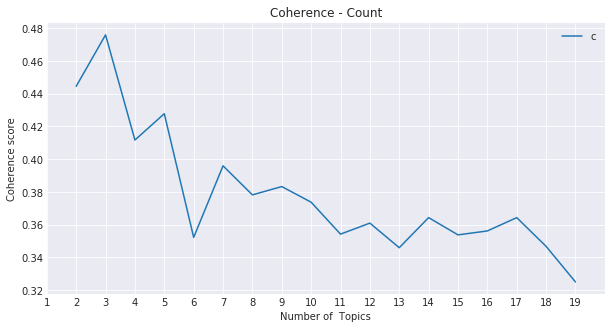

In [5324]:
x = range(2,20, 1)
plt.figure(figsize=(10,5))
plt.plot(x, c_scores_count)
plt.xlim(1,20)
plt.xticks(np.arange(1, 20, step=1))
plt.title("Coherence - Count")
plt.xlabel("Number of  Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_score"), loc='best')
plt.show()

In [4805]:
# Run several LDA models with count vect as input to find optimal topic count
models_LDA_tfidf, c_scores_tfidf = coherence_search(dictionary_t,corpus_plot_t,lyrics_text_t,20)

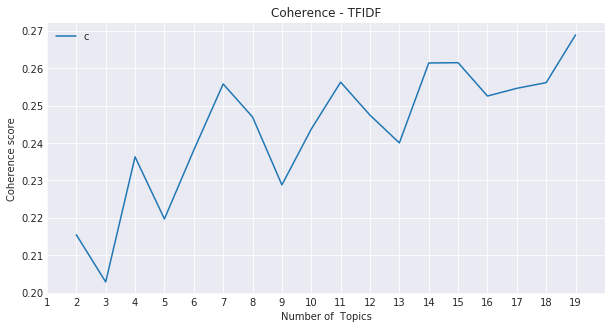

In [4806]:
x = range(2,20, 1)
plt.figure(figsize=(10,5))
plt.plot(x, c_scores_tfidf)
plt.xlim(1,20)
plt.xticks(np.arange(1, 20, step=1))
plt.title("Coherence - TFIDF")
plt.xlabel("Number of  Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_score"), loc='best')
plt.show()

In [5346]:
pyLDAvis.gensim.prepare(models_LDA_count[3], corpus_plot, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.034177 -0.011914       1        1  25.276684
4     -0.031349  0.046064       2        1  21.897470
3      0.001566 -0.050971       3        1  18.385004
2      0.062525  0.017884       4        1  17.371618
1      0.001434 -0.001064       5        1  17.069227, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
152   Default  13.000000      news  13.000000  30.0000  30.0000
60    Default  80.000000        no  80.000000  29.0000  29.0000
345   Default   8.000000     outta   8.000000  28.0000  28.0000
220   Default  14.000000      wait  14.000000  27.0000  27.0000
166   Default  26.000000      turn  26.000000  26.0000  26.0000
196   Default  12.000000    caught  12.000000  25.0000  25.0000
45    Default  10.000000    heaven  10.000000  24.0000  24.0000
372   Default   6.000000     spent   6.000000  23.0000  23.0000
173   Default   8.000000       bag   8.000000  22.0000  22.0000
3     Default  29.000000      damn  29.000000  21.0000  21.0000
91    Default  19.000000     broke  19.000000  20.0000  20.0000
420   Default  10.000000  thousand  10.000000  19.0000  19.0000
368   Default   9.000000        mo   9.000000  18.0000  18.0000
281   Default  14.000000   problem  14.000000  17.0000  17.0000
473   Default  18.000000       chi  18.000000  16.0000  16.0000
28    Default   7.000000     angel   7.000000  15.0000  15.0000
255   Default  20.000000     world  20.000000  14.0000  14.0000
622   Default  11.000000      send  11.000000  13.0000  13.0000
44    Default  29.000000      hear  29.000000  12.0000  12.0000
360   Default   9.000000      tear   9.000000  11.0000  11.0000
103   Default  40.000000      good  40.000000  10.0000  10.0000
272   Default  10.000000      hope  10.000000   9.0000   9.0000
24    Default  12.000000       set  12.000000   8.0000   8.0000
333   Default  13.000000     doing  13.000000   7.0000   7.0000
228   Default   9.000000     fight   9.000000   6.0000   6.0000
118   Default  10.000000       pay  10.000000   5.0000   5.0000
466   Default   6.000000      jean   6.000000   4.0000   4.0000
577   Default   7.000000      dark   7.000000   3.0000   3.0000
248   Default   7.000000      pack   7.000000   2.0000   2.0000
58    Default  11.000000        mr  11.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
53     Topic5   7.692080      long  23.799957   0.6384  -5.2157
44     Topic5   8.668411      hear  29.168804   0.5545  -5.0962
206    Topic5  10.211861       god  37.521362   0.4665  -4.9323
280    Topic5   9.057399     night  32.201626   0.4995  -5.0523
517    Topic5   5.341902      word  15.704374   0.6895  -5.5803
407    Topic5   7.987830      home  28.467939   0.4970  -5.1780
54     Topic5  10.338760      look  46.120857   0.2725  -4.9200
18     Topic5  11.351347      love  56.287468   0.1668  -4.8265
77     Topic5   8.893728     thing  38.895760   0.2924  -5.0705
25     Topic5  11.278787      time  59.166847   0.1105  -4.8330
60     Topic5  13.237283        no  80.840881  -0.0416  -4.6728
16     Topic5  13.302167      know  83.999405  -0.0750  -4.6680
23     Topic5  11.073509       say  70.508469  -0.0833  -4.8513
193    Topic5   8.867845      want  46.049538   0.1206  -5.0734
322    Topic5   5.897204     start  20.153440   0.5390  -5.4814
67     Topic5   8.547347      said  44.411346   0.1200  -5.1103
56     Topic5   9.096073      make  62.192509  -0.1545  -5.0480
19     Topic5   8.065001       man  49.051903  -0.0375  -5.1683
3      Topic5   6.627056      damn  29.377068   0.2788  -5.3647
10     Topic5   7.191731      fuck  36.938377   0.1316  -5.2829
17     Topic5   7.945683      life  49.551723  -0.0625  -5.1832
115    Topic5   8.473000     nigga  63.603577  -0.2479  -5.1190
293    Topic5   6.583853       til  29.671261   0.2623  -5.

In [4410]:
# import plotly.plotly as py
# import plotly.graph_objs as go

In [4411]:
# N = len(album_list)
# random_x = np.linspace(0, 1, N)
# random_y0 = for in 
# random_y1 = np.random.randn(N)
# random_y2 = np.random.randn(N)-5

# # Create traces
# trace0 = go.Scatter(
#     x = random_x,
#     y = random_y0,
#     mode = 'lines',
#     name = 'Topic - 1'
# )
# trace1 = go.Scatter(
#     x = random_x,
#     y = random_y1,
#     mode = 'lines',
#     name = 'Topic - 1'
# )
# trace2 = go.Scatter(
#     x = random_x,
#     y = random_y2,
#     mode = 'lines',
#     name = 'Topic - 2'
# )
# data = [trace0, trace1, trace2]

# py.iplot(data, filename='line-mode')

### 2.2 Word2Vec

In [3212]:
from gensim.models import Word2Vec
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5350]:
def tsne_plot(model):
    #Creates and plot a TSNE model
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=3, init='pca', n_iter=2500, random_state=42, learning_rate=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

#### Train and plot word 2 vec

In [5629]:
# train model
model = Word2Vec(text_corpus_w2v, size=50,seed=42, min_count=10, window = 5, iter=100)
# summarize the loaded model
print(model)

Word2Vec(vocab=514, size=50, alpha=0.025)


In [5643]:
model.most_similar('myself')

[('bed', 0.5850050449371338),
 ('killing', 0.5635855793952942),
 ('killed', 0.5398204326629639),
 ('dawg', 0.5226340293884277),
 ('loving', 0.5117295384407043),
 ('wake', 0.5074575543403625),
 ('hood', 0.5013218522071838),
 ('favorite', 0.4675023555755615),
 ('door', 0.4619908332824707),
 ('catch', 0.44258543848991394)]

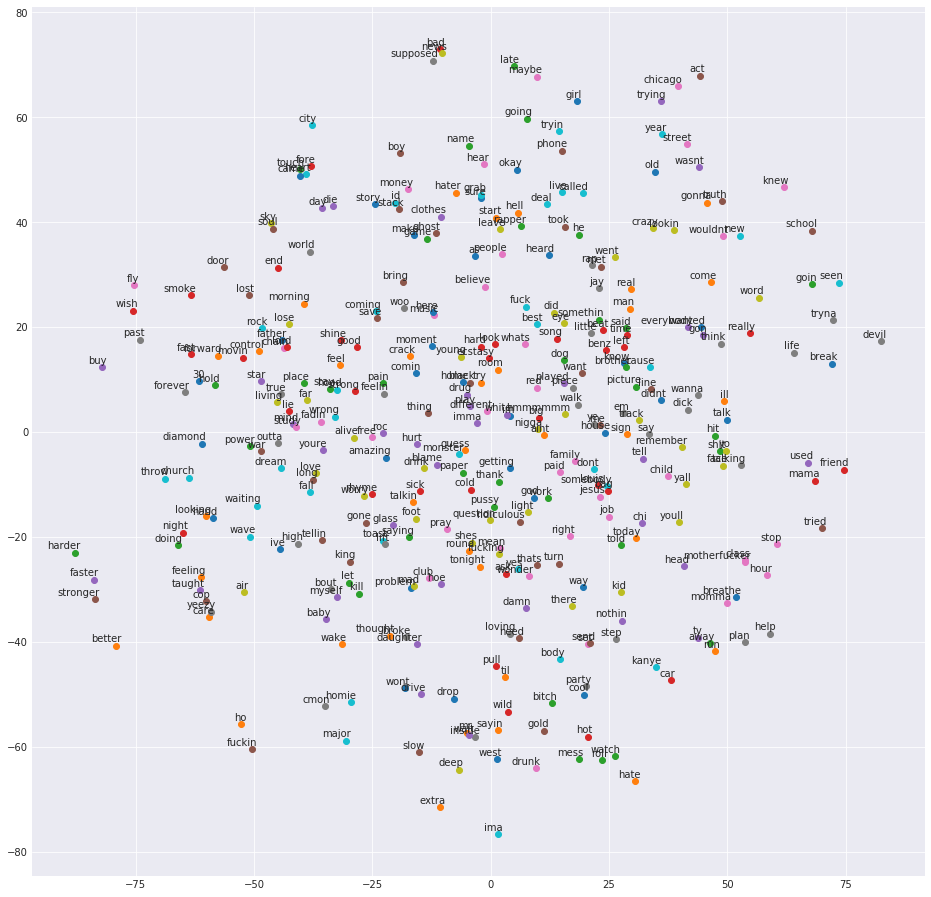

In [5351]:
tsne_plot(model)

### Silhouette Score

In [5347]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [5348]:
X = df_cvec
cluster_labels = df_lyrics['label']
silhouette = silhouette_score(X, cluster_labels)
silhouette

-0.03722535050989923

In [5349]:
sil_per_topic = silhouette_samples(X,cluster_labels)
sil_per_topic

array([-3.17777872e-02, -5.65727654e-02,  3.49440645e-02,  5.53552891e-02,
        7.31602885e-02, -5.60150533e-02, -6.10815762e-03, -4.23146307e-02,
       -4.32117214e-02, -4.57635756e-02,  1.08646271e-01, -9.76041021e-02,
       -4.91770287e-02,  1.08752286e-01, -5.77153337e-02, -7.46171328e-02,
       -4.89905345e-02, -6.24770783e-03,  2.81916998e-03, -1.46696204e-01,
       -3.88834711e-02, -2.56684766e-02, -5.44225323e-02, -6.90498697e-02,
       -9.23098285e-02, -6.65589114e-02, -2.27216672e-02, -8.63804561e-02,
       -2.07215329e-01, -3.10174375e-02, -1.68058478e-02, -1.84959740e-02,
       -8.32284415e-02, -7.36723536e-02, -1.11862500e-01, -2.35934492e-02,
        5.20420372e-02, -1.17873811e-01, -1.09516793e-01, -2.54507174e-02,
       -6.38637387e-02, -1.05412554e-01,  2.47150776e-02,  4.50384682e-02,
       -4.69810861e-02,  6.88943227e-02,  6.78774799e-02, -6.05996915e-02,
       -9.01487860e-02,  5.73481554e-02, -4.49061413e-02,  7.43725900e-03,
       -8.72392033e-02, -

In [5369]:
# Values near 0 indicate overlapping clusters.

#### K-Means (not completed)

In [5371]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [5373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=cluster_labels, random_state=42)

In [ ]:
clusterer = KMeans(n_clusters=5, random_state=42)
cluster_labels = clusterer.fit_predict(X)

### 2.3 Sequential LDA

In [5374]:
from gensim.models import LdaSeqModel

In [5405]:
# Will attempt a sequential LDA model based on year release

In [5444]:
df_lyrics.drop(labels=90,inplace=True);

In [5445]:
corpus_lem_seq = df_lyrics.sort_values('release_year')['lyrics_lemmatized']

In [5446]:
cvec_seq = CountVectorizer(min_df=5,
                       max_df=0.95,
                       stop_words=stop,
                       ngram_range=(1,1),
                      )
count_seq = cvec_seq.fit_transform(corpus_lem_seq);

In [5447]:
df_cvec_seq  = pd.DataFrame(cvec_seq.transform(corpus_lem_seq).todense(),
                   columns=cvec_seq.get_feature_names(),
                   index=df_lyrics.sort_values('release_year')['name'])

In [5448]:
lyrics_text_seq = [df_cvec_seq.columns[df_cvec_seq.loc[index,:].nonzero()] for index in df_cvec_seq.index]
dictionary_seq = corpora.Dictionary(lyrics_text_seq)

corpus_plot_seq = [dictionary_seq.doc2bow(text) for text in lyrics_text_seq]

In [5449]:
df_lyrics['release_date'] = pd.to_datetime(df_lyrics['release_date'])
df_lyrics['release_year'] = df_lyrics.release_date.dt.year

In [5523]:
base = 2004
i = 0
years= [base]
year_list = []
for year in df_lyrics.sort_values('release_date')['release_year']:
    if year == base:
        i += 1
    else:
        year_list.append(i)
        base = year
        i = 1
        years.append(year)
year_list.append(i)
year_list

[20, 21, 13, 12, 13, 10, 20, 17]

In [5524]:
years

[2004, 2005, 2007, 2008, 2010, 2013, 2016, 2018]

In [5490]:
ldaseq = LdaSeqModel(corpus=corpus_plot_seq, time_slice=year_list, id2word=dictionary, num_topics=10, chain_variance=0.05)

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:1472: RuntimeWarning:

invalid value encountered in double_scalars

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:290: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:1472: RuntimeWarning:

invalid value encountered in double_scalars

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:1472: RuntimeWarning:

invalid value encountered in double_scalars

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:1472: RuntimeWarning:

invalid value encountered in double_scalars

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:1472: RuntimeWarning:

invalid value encountered in double_scalars

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.

In [5503]:
for i in range(0,len(year_list)):
    print(ldaseq.print_topic(7,time=i,top_terms=5))

[('sex', 0.009711396330016744), ('soon', 0.009660804633192067), ('knew', 0.008500690885110962), ('drop', 0.008253834986350935), ('second', 0.007870123767130918)]
[('soon', 0.010245790172449759), ('sex', 0.009661292494484374), ('knew', 0.008946141593956347), ('mr', 0.007966201700379231), ('drop', 0.0077956341834859826)]
[('soon', 0.010818040427603062), ('knew', 0.009473625449766964), ('sex', 0.00946311561587161), ('mr', 0.008448179900967303), ('hate', 0.007851020796168257)]
[('soon', 0.011019116109053019), ('knew', 0.00962442542740018), ('sex', 0.008965643034429597), ('mr', 0.008897253384516654), ('hate', 0.007869659185168994)]
[('soon', 0.011407050133354605), ('knew', 0.009907558994926041), ('mr', 0.009009440336924792), ('sex', 0.008658662367080457), ('dead', 0.008544384806084082)]
[('soon', 0.011343419744893503), ('knew', 0.010330691392495912), ('dead', 0.00906770041087017), ('myself', 0.008611695924390025), ('sex', 0.00855192689240044)]
[('soon', 0.011108833802641632), ('knew', 0.010

In [5502]:
ldaseq.time_slice

[20, 21, 13, 12, 13, 10, 20, 17]

In [5539]:
topic_7_seq = pd.DataFrame(columns=['year','word','prop'])
topic_word = []
topic_year = []
topic_prop = []

for year in years:
    topic_current = ldaseq.print_topic(7, time=[i for i,x in enumerate(years) if x == year][0],top_terms=10)
    for line in topic_current:
        topic_year.append(year)
        topic_word.append(line[0])
        topic_prop.append(line[1])
        
topic_7_seq['year'] = topic_year
topic_7_seq['word'] = topic_word
topic_7_seq['prop'] = topic_prop
topic_7_seq.head()

,year,word,prop
0,2004,sex,0.009711
1,2004,soon,0.009661
2,2004,knew,0.008501
3,2004,drop,0.008254
4,2004,second,0.007870


In [5589]:
def word_list_maker(word):
    return_list=[]
    df_temp_2 = topic_7_seq.loc[topic_7_seq['word'] == word]
    for year in years:
        lll = list(df_temp_2.loc[df_temp_2['year'] == year].prop.values)
        if len(lll) == 0:
            return_list.append(0)
        else:
            return_list.append(lll[0])
    return return_list

In [5598]:
df_temp = topic_7_seq.groupby('word').mean()
sequential_words = []
for word in df_temp.index:
    sequential_words.append(word_list_maker(word))

In [5600]:
df_temp.index

Index(['close', 'dead', 'drop', 'hate', 'knew', 'lay', 'live', 'mr', 'myself',
       'second', 'sex', 'shot', 'soon', 'supposed'],
      dtype='object', name='word')

In [5612]:
N = len(years)
random_x = years
y0 = sequential_words[1]
y1 = sequential_words[3]
y2 = sequential_words[10]
y3 = sequential_words[7]

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = y0,
    mode = 'lines',
    name = 'dead'
)
trace1 = go.Scatter(
    x = random_x,
    y = y1,
    mode = 'lines',
    name = 'hate'
)
trace2 = go.Scatter(
    x = random_x,
    y = y2,
    mode = 'lines',
    name = 'sex'
)
trace3 = go.Scatter(
    x = random_x,
    y = y3,
    mode = 'lines',
    name = 'myself'
)
data = [trace0, trace1, trace2,trace3]

layout = go.Layout(
    yaxis=dict(
        range=[0.006, 0.01]
    ))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='line-mode')